### v1: scaler used is MinMaxScaler

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import jupyterthemes as jt
jt.jtplot.style(theme = 'grade3', context = 'paper', ticks=True, grid = False)

### DBSCAN

In [213]:
from sklearn.cluster import DBSCAN

    * High dimensions not conducive for DBSCAN but ignored here for the sake of consistency

#### Choosing min_samples

    * A good starting point for min_samples is from the counts from groupby method

In [218]:
groupby_charge_type.ngroup()

0        6
1        8
2        5
3        8
4        9
        ..
9995    10
9996     8
9997     5
9998     8
9999     3
Length: 10000, dtype: int64

In [223]:
np.unique(groupby_charge_type.ngroup(), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 523,  327,  154,  170, 1946,  918,  402,  462, 1947, 1028,  417,
         471,  565,  335,  166,  169]))

In [225]:
min_samples = min(np.unique(groupby_charge_type.ngroup(), return_counts=True)[1])
min_samples

154

#### Choosing distance metric for calculating $\epsilon$

    * many available (see sklearn.metrics.pairwise_distances): choosing euclidean

In [226]:
dist_metric = 'euclidean'

    * Since all predictors have been scaled between 0 and 1, using n predictors, max $\epsilon$ should be $\sqrt{n}$.
    
    * Therefore, $\epsilon$ can be anywhere between 0 and $\sqrt{n}$.

In [227]:
# example
from scipy.spatial import distance

In [229]:
distance.euclidean([1,1,1,1,1],[0,0,0,0,0])

2.23606797749979

In [230]:
# 16 predictors, therefore max is 4
eps_search = np.arange(0.25,4.75, 0.75)
eps_search

array([0.25, 1.  , 1.75, 2.5 , 3.25, 4.  ])

#### $\epsilon$ = 0.25

In [247]:
dbscan = DBSCAN(eps = eps_search[0], min_samples=min_samples, metric = dist_metric, n_jobs=3)

In [248]:
dbscan_25 = dbscan.fit(train_data[:,:16])

In [249]:
dbscan_25.core_sample_indices_.shape

(3963,)

In [250]:
np.unique(dbscan_25.labels_, return_counts=True)

(array([-1,  0,  1]), array([1933, 4110, 3957]))

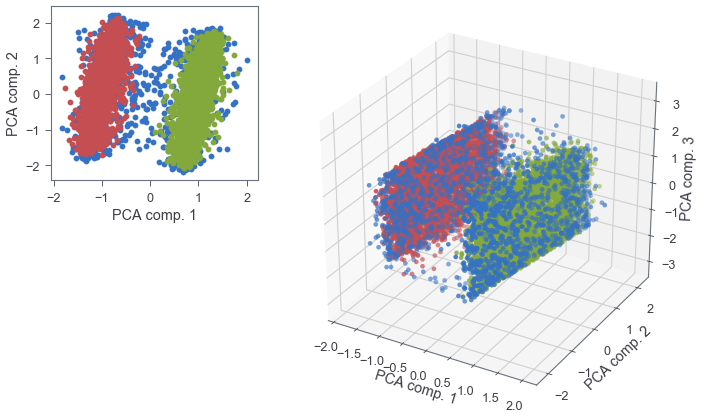

In [251]:
plot_func(train_data[:,:16], dbscan_25.labels_)

#### $\epsilon$ = 1.0

In [244]:
eps_search[1]

1.0

In [252]:
dbscan = DBSCAN(eps = eps_search[1], min_samples=min_samples, metric = dist_metric, n_jobs=3)

In [253]:
dbscan_100 = dbscan.fit(train_data[:,:16])

In [255]:
dbscan_100.core_sample_indices_.shape

(9994,)

In [256]:
np.unique(dbscan_100.labels_, return_counts=True)

(array([0]), array([10000]))

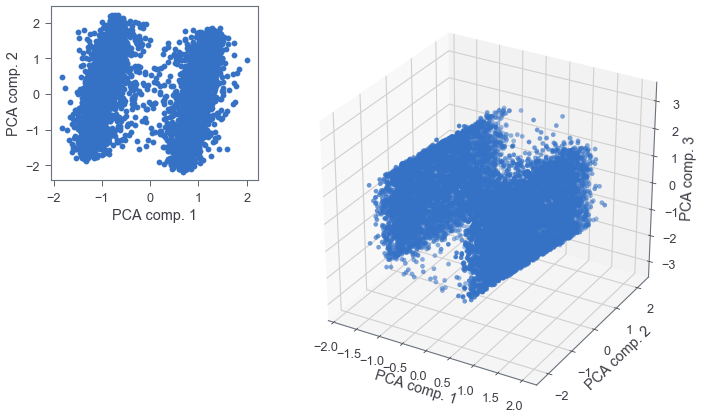

In [257]:
plot_func(train_data[:,:16], dbscan_100.labels_)

    * For $\epsilon$ = 1.0, only 1 cluster, 
    * Implies for values greater than 1.0, the same should be expected. Checking below. 

#### $\epsilon$ = 2.0

In [258]:
eps_search[2]

1.75

In [259]:
dbscan = DBSCAN(eps = eps_search[2], min_samples=min_samples, metric = dist_metric, n_jobs=3)

In [260]:
dbscan_175 = dbscan.fit(train_data[:,:16])

In [261]:
dbscan_175.core_sample_indices_.shape

(10000,)

In [262]:
np.unique(dbscan_175.labels_, return_counts=True)

(array([0]), array([10000]))

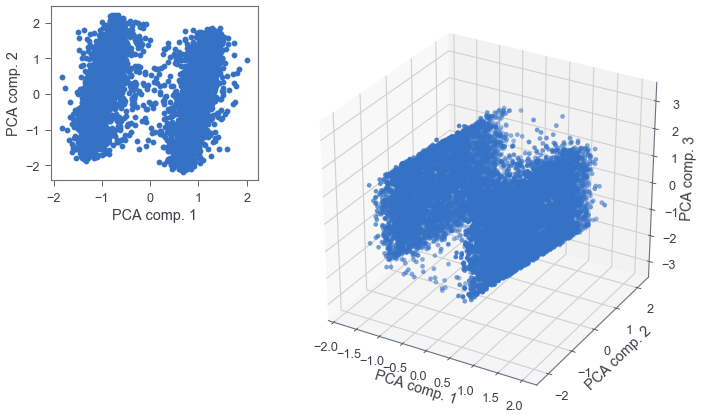

In [263]:
plot_func(train_data[:,:16], dbscan_175.labels_)

    * Confirmed

In [264]:
eps_search

array([0.25, 1.  , 1.75, 2.5 , 3.25, 4.  ])

In [268]:
# new range
np.delete(eps_search, np.s_[1:len(eps_search)])

array([0.25])

In [273]:
eps_search = np.arange(0.3, 0.6, 0.1)

#### $\epsilon$ = 0.3

In [274]:
eps_search[0]

0.3

In [275]:
dbscan = DBSCAN(eps = eps_search[0], min_samples=min_samples, metric = dist_metric, n_jobs=3)

In [277]:
dbscan_30 = dbscan.fit(train_data[:,:16])

In [278]:
dbscan_30.core_sample_indices_.shape

(6666,)

In [279]:
np.unique(dbscan_30.labels_, return_counts=True)

(array([-1,  0,  1]), array([ 551, 4789, 4660]))

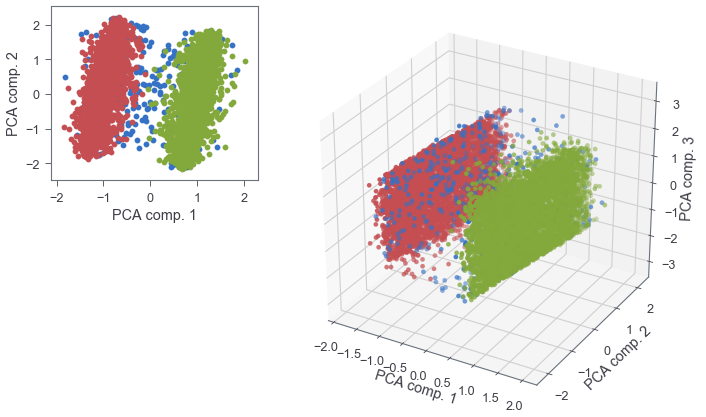

In [280]:
plot_func(train_data[:,:16], dbscan_30.labels_)

    * The blue points are noise or outliers

##### Silhouette Analysis

In [298]:
mshift_nocat_bw1[(mshift_nocat_bw1==0) | (mshift_nocat_bw1==1)]

array([1, 0, 0, ..., 0, 0, 0])

In [301]:
silhouette_score(train_data[:,:16], dbscan_30.labels_)

0.31079135027534704

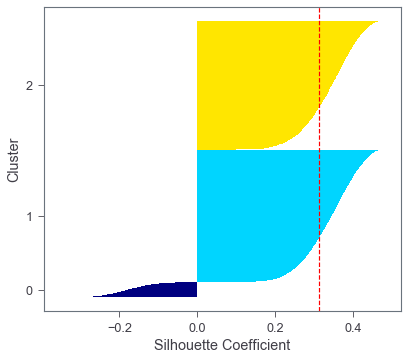

In [302]:
silhouette_plot(train_data[:,:16],dbscan_30.labels_)

#### $\epsilon$ = 0.4

In [281]:
eps_search[1]

0.4

In [282]:
dbscan = DBSCAN(eps = eps_search[1], min_samples=min_samples, metric = dist_metric, n_jobs=3)

In [283]:
dbscan_40 = dbscan.fit(train_data[:,:16])

In [284]:
dbscan_40.core_sample_indices_.shape

(9181,)

In [285]:
np.unique(dbscan_40.labels_, return_counts=True)

(array([-1,  0]), array([  81, 9919]))

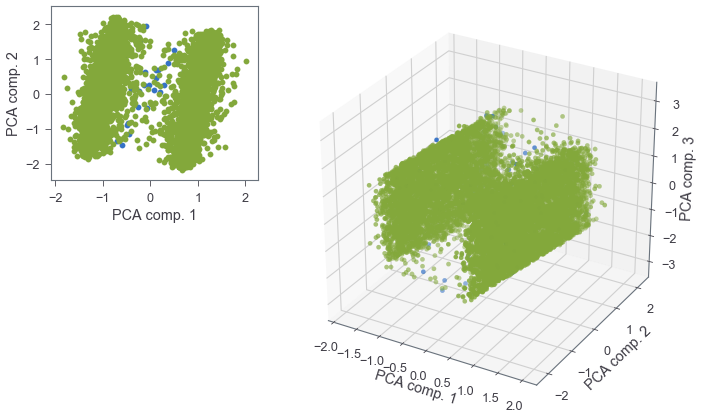

In [286]:
plot_func(train_data[:,:16], dbscan_40.labels_)

    * So, eps = 0.3 is able to resolve the data into clusters and outliers

#### Examining the properties of the clusters

In [303]:
np.unique(dbscan_30.labels_, return_counts=True)

(array([-1,  0,  1]), array([ 551, 4789, 4660]))

    * So cluster 0 and 1 are the main ones, -1 is outliers

In [304]:
np.unique(train_data[:,16:][dbscan_30.labels_==0], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 66,  72, 170, 244, 211, 183, 499, 962, 229, 171, 469, 962,  82,
         72, 168, 229]))

In [305]:
np.unique(train_data[:,16:][dbscan_30.labels_==1], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([ 78,  75, 147, 263, 219, 199, 493, 924, 210, 207, 423, 917,  71,
         57, 137, 240]))

In [306]:
np.unique(train_data[:,16:][dbscan_30.labels_==-1], return_counts=True, axis=0)

(array([[0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 1.],
        [0., 1., 0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0., 1., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.]]),
 array([25, 19, 18, 58, 41, 35, 36, 61, 23, 24, 26, 67, 17, 25, 22, 54]))

    * Same combination for outliers too

##### Ratio of counts

In [307]:
dbscan_countsratio = np.unique(train_data[:,16:][dbscan_30.labels_==0], return_counts=True,  axis=0)[1]/\
np.unique(train_data[:,16:][dbscan_30.labels_==1], return_counts=True, axis=0)[1]
dbscan_countsratio

array([0.84615385, 0.96      , 1.15646259, 0.92775665, 0.96347032,
       0.91959799, 1.01217039, 1.04112554, 1.09047619, 0.82608696,
       1.10874704, 1.04907306, 1.15492958, 1.26315789, 1.22627737,
       0.95416667])

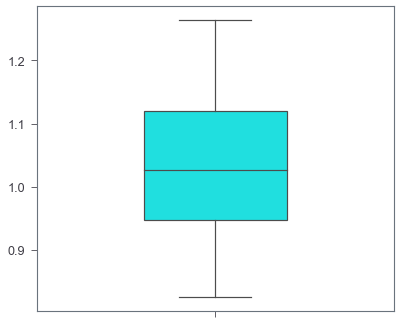

In [308]:
sns.boxplot(dbscan_countsratio, orient = 'v', width=0.4, color = 'cyan' )

    * No outliers, so the clustering did not yield results based on the particle charge or type or both.